In [1]:
import anndata
import phate
import scprep
import sklearn
import scanpy as sc
import magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphtools
import seaborn as sns

import SPARC
import tasklogger
import warnings

from scipy.spatial.distance import pdist, squareform, jensenshannon
warnings.simplefilter('ignore')

In [3]:
adata = sc.datasets.visium_sge(sample_id='V1_Adult_Mouse_Brain')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata

AnnData object with n_obs × n_vars = 2698 × 31053
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)


<AxesSubplot:xlabel='n_genes_by_counts'>

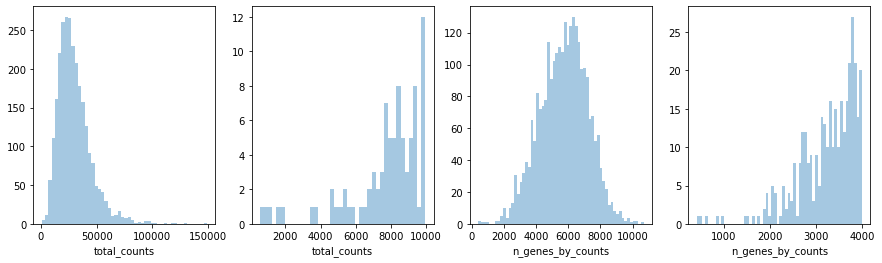

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])


In [7]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=75000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

#cells after MT filter: 2647


Trying to set attribute `.var` of view, copying.


In [8]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [9]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


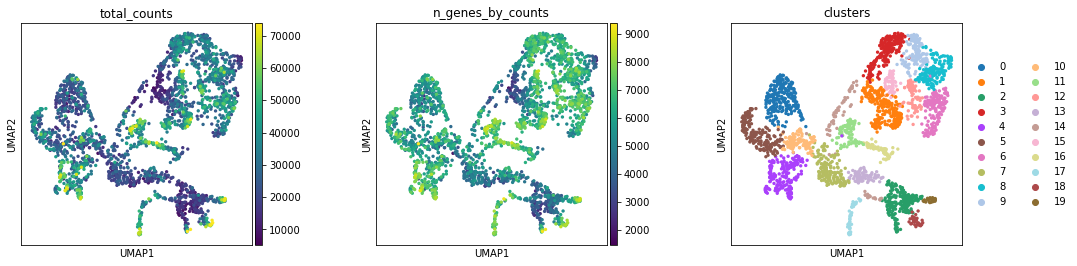

In [10]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

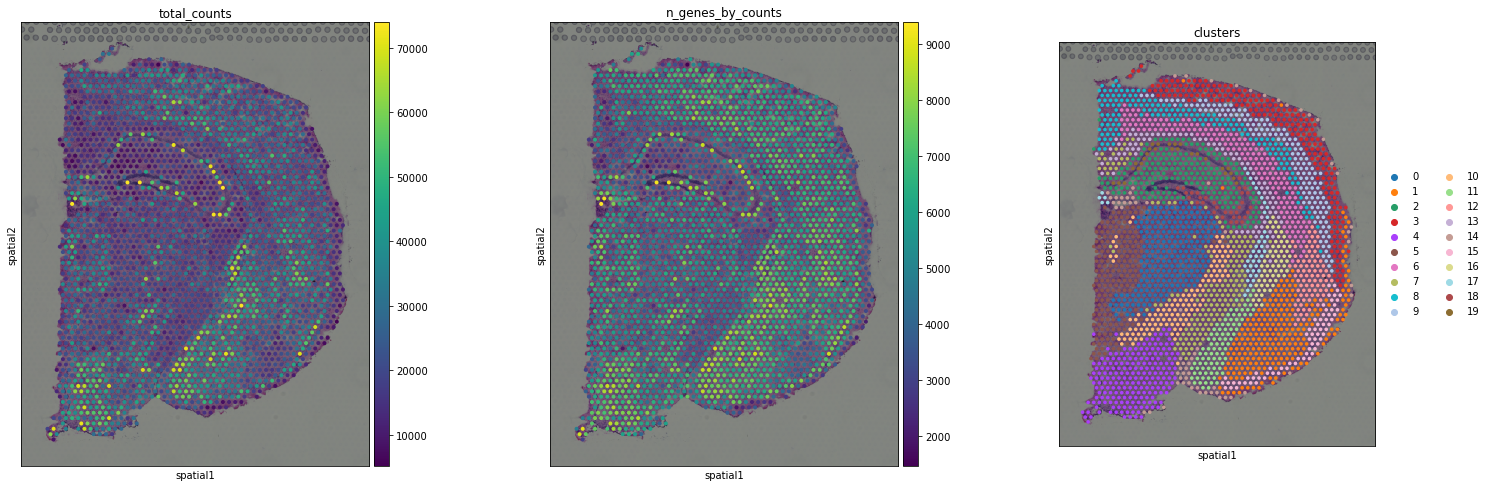

In [11]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts", "clusters"])

In [12]:
### spatial smoothing with chebyshev

In [14]:
### Testing spARC

In [15]:
sparc_op = spARC()

In [16]:
data_sparc = sparc_op.fit_transform(expression_X = adata.to_df(),
                                    spatial_X = adata.obs[['array_row', 'array_col']])

Calculating spARC...
  Calculating PCA...
  Calculated PCA in 10.76 seconds.
  Calculating expression graph...
  Calculated expression graph in 0.69 seconds.
  Calculating spatial graph...
  Calculated spatial graph in 0.05 seconds.
  Calculating random walks on expression graph...
  Calculated random walks on expression graph in 1.99 seconds.
  Calculating random walks on spatial graph...
  Calculated random walks on spatial graph in 0.06 seconds.
  Calculating spARCed expression data...
  Calculated spARCed expression data in 40.50 seconds.
Calculated spARC in 54.06 seconds.


In [17]:
adata.layers['rna_raw'] = adata.to_df()
adata.layers['rna_sparc'] = data_sparc

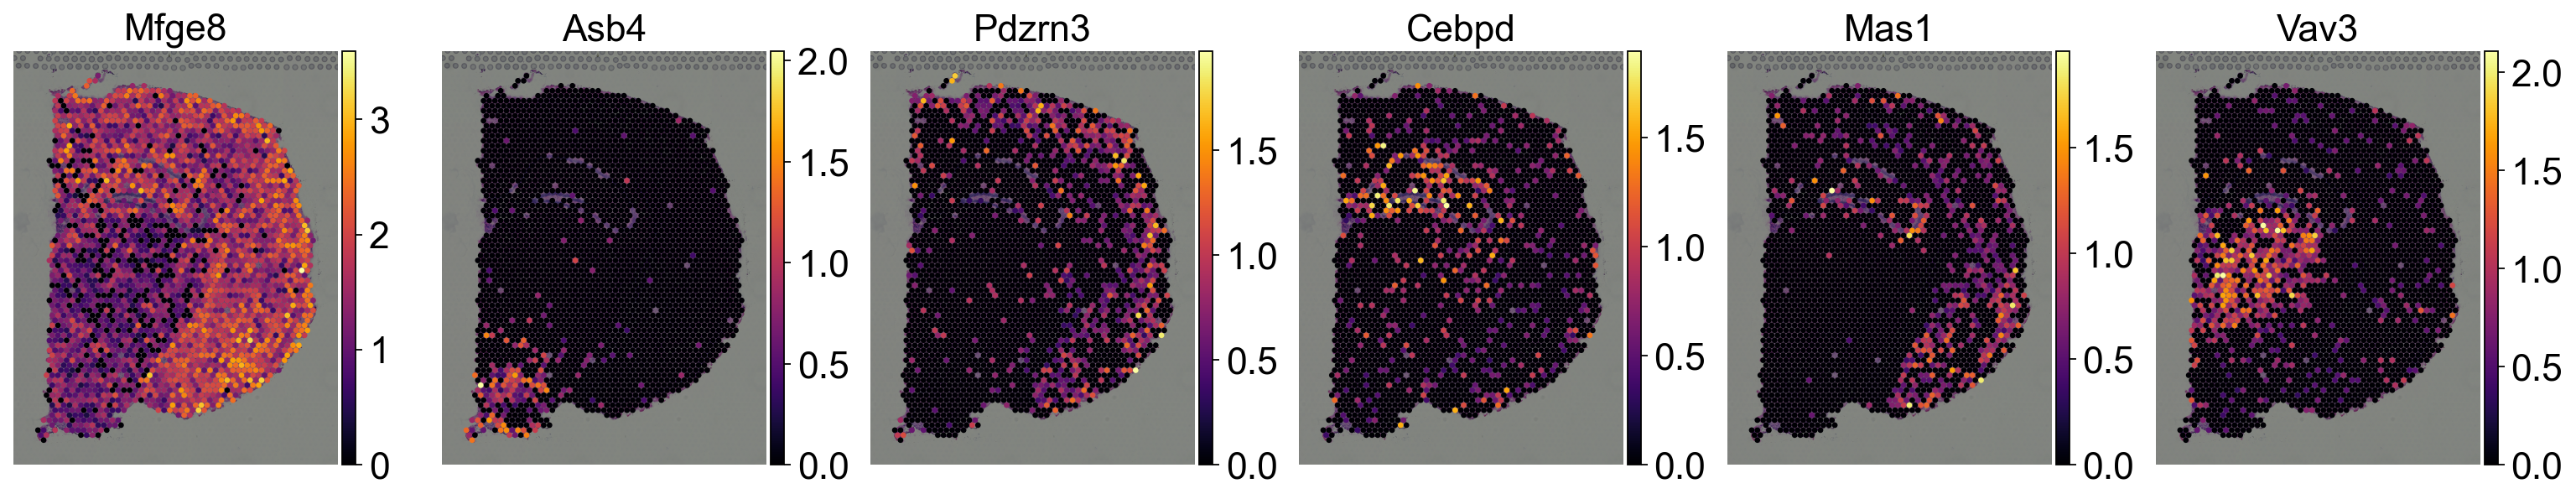

In [18]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_raw', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

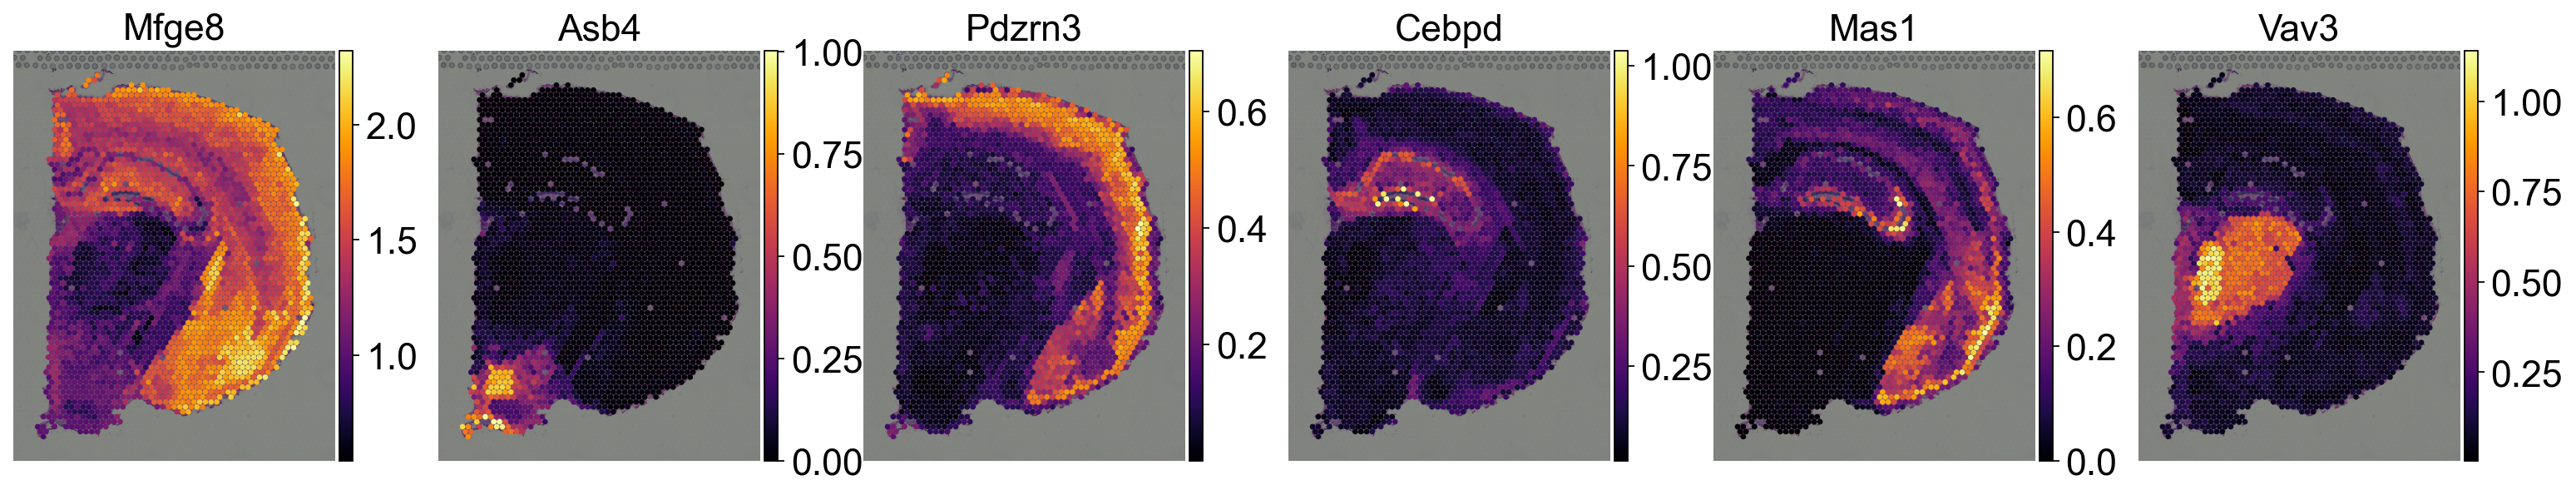

In [19]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_sparc', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

In [20]:
## testing with different parameters

In [21]:
G_rna = graphtools.Graph(adata.obsm['X_pca'], knn=5)

import numpy as np
spatial_data = np.array(adata.obs[['array_row', 'array_col']])
G_spatial = graphtools.Graph(spatial_data, knn=3)

In [22]:
sparc_op = spARC(expression_graph=G_rna, spatial_graph=G_spatial)
data_sparc = sparc_op.fit_transform(expression_X = adata.to_df())

Calculating spARC...
  Calculating PCA...
  Calculated PCA in 21.49 seconds.
  Calculating expression graph...
  Calculating spatial graph...
  Calculating random walks on expression graph...
  Calculated random walks on expression graph in 3.27 seconds.
  Calculating random walks on spatial graph...
  Calculated random walks on spatial graph in 0.08 seconds.
  Calculating spARCed expression data...
  Calculated spARCed expression data in 46.71 seconds.
Calculated spARC in 71.56 seconds.


In [23]:
adata.layers['rna_raw'] = adata.to_df()
adata.layers['rna_sparc'] = data_sparc

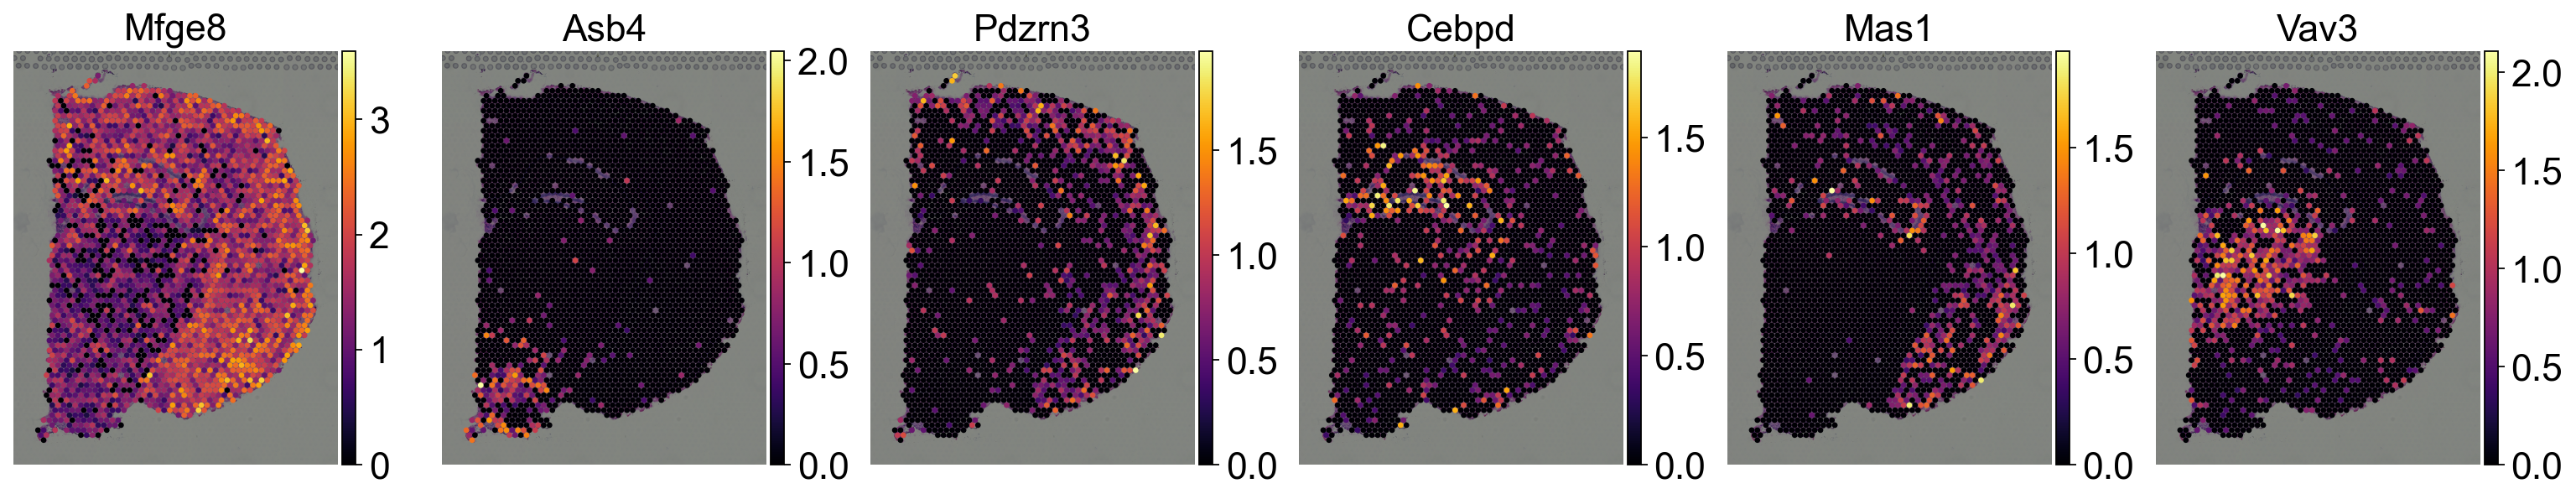

In [24]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_raw', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

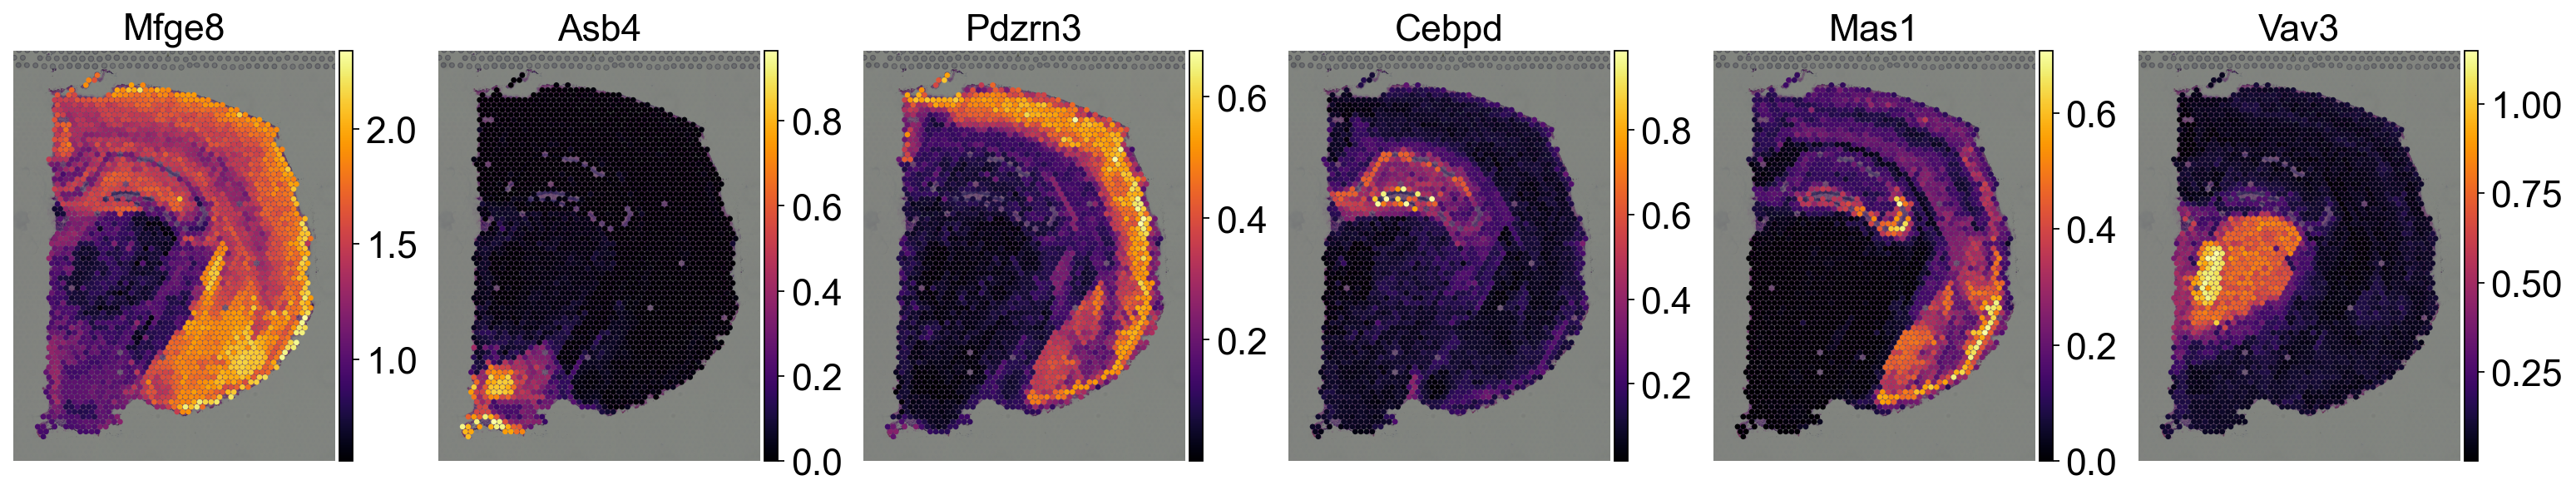

In [25]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='rna_sparc', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)

In [27]:
### soluable
G_spatial = graphtools.Graph(spatial_data, knn=5)
soluable_sparc = sparc_op.diffuse_soluable_factors(soluable_spatial_graph=G_spatial)

Calculating random walks on spatial graph...
Calculated random walks on spatial graph in 5.71 seconds.
Calculating diffusion on soluable factors...
Calculated diffusion on soluable factors in 16.27 seconds.


In [28]:
adata.layers['soluable_sparc'] = soluable_sparc

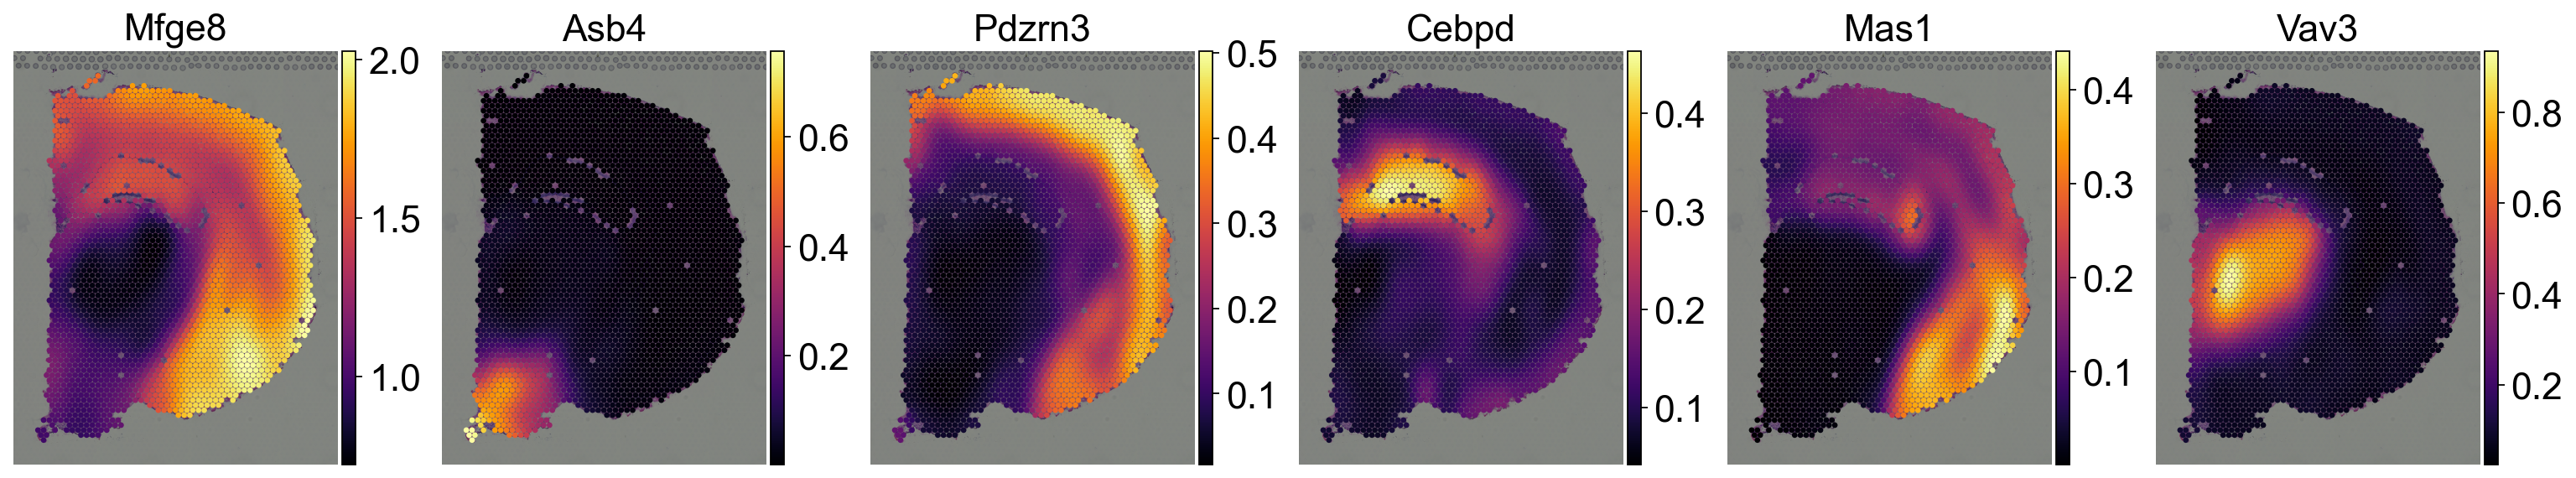

In [29]:
plt.rcParams["figure.figsize"] = (2, 2)
#plt.rcParams['figure.facecolor'] = 'white'
sc.set_figure_params(facecolor='white', transparent=True, frameon=False, fontsize=20)
sc.pl.spatial(adata, layer='soluable_sparc', img_key="hires", size=1.5,legend_fontsize=14, ncols=6, wspace=0,
                  cmap='inferno', color=['Mfge8', 'Asb4', 'Pdzrn3', 'Cebpd', 'Mas1', 'Vav3'],
              alpha_img=1, frameon=False)